# Pyreflect Reflectivity Pipeline Example

This notebook demonstrates the example workflow with clearer, annotated steps. It shows how to go from neutron reflectivity (NR) curves to scattering length density (SLD) profiles using `pyreflect`.


## 1. Environment setup

Use the following cells to make sure PyTorch and pyreflect are available. Installation is commented out so you can enable it only if needed.


In [ ]:
# Uncomment if ipykernel is needed in this environment. Skip for windows.

!curl -fsSLo setup.sh https://raw.githubusercontent.com/williamQyq/pyreflect/main/setup.sh
!bash setup.sh

### 1.1 Install `pyreflect`

`Note`: Install may takes some times and restart Kernel after installation

In [ ]:
# Uncomment if pyreflect is not installed in this environment.
# Installation may takes some times
!pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple pyreflect==1.3.14

In [ ]:
!pip show pyreflect

In [2]:
import platform, sys, importlib

def safe_version(pkg):
    try:
        module = importlib.import_module(pkg)
        return getattr(module, "__version__", "unknown")
    except ModuleNotFoundError:
        return "not installed"

print(f"Python: {sys.version.split()[0]} ({platform.system()} {platform.release()})")
print(f"PyTorch: {safe_version('torch')}")

try:
    import torch
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("CUDA device:", torch.cuda.get_device_name(0))
except ModuleNotFoundError:
    pass

Python: 3.10.19 (Windows 10)
PyTorch: 2.9.1+cpu
CUDA available: False


In [3]:
!conda env list


# conda environments:
#
# * -> active
# + -> frozen
                         C:\Users\qyqfi\anaconda3
                         C:\Users\qyqfi\anaconda3\envs\pyreflect
base                     C:\Users\qyqfi\miniconda3
Pyreflect-repo       *   C:\Users\qyqfi\miniconda3\envs\Pyreflect-repo
pyreflect                C:\Users\qyqfi\miniconda3\envs\pyreflect



## 2. Paths and data overview

We keep all paths together for clarity. The repo already ships generated train/test splits and a pretrained model so you can run inference quickly.


In [56]:
from pathlib import Path
import numpy as np

ROOT = Path(".")
TRAIN_NR = ROOT / "data/curves/X_train_5_layers.npy"
TRAIN_SLD = ROOT / "data/curves/y_train_5_layers.npy"
TEST_NR = ROOT / "data/curves/X_test_5_layers.npy"
TEST_SLD = ROOT / "data/curves/y_test_5_layers.npy"
PRETRAINED_MODEL = ROOT / "data/trained_nr_sld_model_no_dropout.pth"
NORMALIZATION_STAT = ROOT / "data/normalization_stat.npy"

for path in [TRAIN_NR, TRAIN_SLD, TEST_NR, TEST_SLD, PRETRAINED_MODEL, NORMALIZATION_STAT]:
    assert path.exists(), f"Missing file: {path}"
print("All expected files are present.")

All expected files are present.


## 2.1 Configuration Overview
We load and inspect the NR → SLD pipeline configuration:

In [ ]:
import sys
!{sys.executable} -m pyreflect init --force

In [31]:
root = "./"
config = pyreflect.config.load_config(root)
pprint(config["nr_predict_sld"])

{'file': {'experimental_nr_file': 'data/curves/experimental_nr_curves.npy',
          'nr_curves_poly': 'data/curves/nr_curves_poly.npy',
          'reflectivity_model_bounds': 'data/curves/reflectivity_model_bounds.json',
          'sld_curves_poly': 'data/curves/sld_curves_poly.npy'},
 'models': {'batch_size': 32,
            'dropout': 0.5,
            'epochs': 10,
            'model': 'data/trained_nr_sld_model.pth',
            'normalization_stats': 'data/normalization_stat.npy',
            'num_curves': 50000,
            'num_film_layers': 5}}


## 3. Dataset Preparation
- We load pre-generated synthetic datasets (already shuffled):
    - NR curves: shape (N, 2, 308) → (Q, R)
    - SLD profiles: shape (N, 2, 900) → (z, ρ)

In [12]:
dproc = NRSLDDataProcessor(TRAIN_NR,TRAIN_SLD).load_data()
dproc._nr_arr.shape, dproc._sld_arr.shape

((63000, 2, 308), (63000, 2, 900))

## 4. Model Architecture & Training
### 4.1 Training Configuration
We configure a CNN model for pure NR → SLD inversion:


In [49]:
model_config = config["nr_predict_sld"]["models"]
# 
model_config["num_film_layers"] = 5
model_config["dropout"] = 0.5
model_config["epochs"] = 10
model_config["model"]=PRETRAINED_MODEL
# cnn model layers
model_config["layers"]=5
model_config["normalization_stats"] = NORMALIZATION_STAT


file_config = config["nr_predict_sld"]["file"]
# training X
file_config["nr_curves_poly"] = TRAIN_NR
# training y
file_config["sld_curves_poly"] = TRAIN_SLD

from pyreflect.models.config import NRSLDModelTrainerParams
trainer_params = NRSLDModelTrainerParams(root,_config = config)
config["nr_predict_sld"]["models"]["layers"]

12

In [33]:
import pyreflect.pipelines.reflectivity_pipeline as workflow

# Use the NRSLDDataProcessor to handle pre-processing
X_train, y_train = workflow.preprocess(dproc,trainer_params.normalization_stats)

## 5. Train or load a model

Set `use_pretrained=True` to skip training and use the bundled weights. Set it to `False` to run a short training session with the sliced data.

The trained model is automatically saved for reuse. The save model path will be `PRETRAINED_MODEL`

In [ ]:
use_pretrained = True

pipeline = workflow.ReflectivityPipeline(None, trainer_params)

if use_pretrained:
    model = pipeline.load_model(str(PRETRAINED_MODEL))
    print(f"Loaded pretrained model from {PRETRAINED_MODEL}")
else:
    # training model
    model = workflow.train_nr_predict_sld_model(X_train, y_train, trainer_params, auto_save=True)

norm_stats = workflow.load_normalization_stat(str(NORMALIZATION_STAT))


### Visualization: NR & SLD Side-by-Side

- Left: Experimental NR vs NR recomputed from predicted SLD

- Right: Ground-truth SLD vs predicted SLD (with/without dropout)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["font.family"] = "DejaVu Sans"   # or "Arial"

def plot_experiment_results(expt_nr_data, expt_sld_data=None,
                            computed_nr_data=None, predicted_sld_data=None):
    """
    Publication-quality plot for AAAI paper: NR & SLD side-by-side.
    """

    # --- Matplotlib style for paper ---
    mpl.rcParams.update({
        "font.size": 8,              # base font size
        "axes.labelsize": 9,
        "axes.titlesize": 9,
        "legend.fontsize": 9,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "lines.linewidth": 1.3,
        "figure.dpi": 300,
    })

    fig, axes = plt.subplots(1, 2, figsize=(6.8, 2.6))  # fits in 2-column width

    # --- Left: Reflectivity (NR) ---
    axes[0].plot(expt_nr_data[0], expt_nr_data[1],
                 color="black", alpha=0.8, linestyle="-",linewidth=2,
                 label="GroundTruth")
    if computed_nr_data is not None:
        axes[0].plot(computed_nr_data[0], computed_nr_data[1],
                     color="black", label="Computed NR", linestyle="--",linewidth=1.3)

    axes[0].set_xlabel("Q (Å⁻¹)")
    axes[0].set_ylabel("Reflectivity NR")
    axes[0].set_yscale("log")

    # Legend inside top-right, small box
    axes[0].legend(frameon=False, loc="lower left", handlelength=2.5)


    # --- Right: SLD Profiles ---
    if expt_sld_data is not None:
        axes[1].plot(expt_sld_data[0], expt_sld_data[1],
                     color="black", alpha=0.8, linestyle="-",linewidth=2,
                     label="GroundTruth")
    if predicted_sld_data is not None:
        axes[1].plot(predicted_sld_data[0], predicted_sld_data[1],
                     color="red", linestyle="--", label="Prediction[model]")

    # if dropout_sld_data is not None:
    #     axes[1].plot(dropout_sld_data[0], dropout_sld_data[1],
    #                  color="blue", linestyle="--", label="Dropout")
    
    axes[1].set_xlabel("Depth (Å)")
    axes[1].set_ylabel("SLD (×10⁻⁶ Å⁻²)")

    axes[1].legend(frameon=False, loc="lower left", handlelength=2.5)

    # --- Remove titles (paper captions describe them) ---
    for ax in axes:
        ax.set_title("")
        ax.tick_params(direction="in", length=2.5)

    plt.tight_layout(pad=1.0, w_pad=1.4)
    plt.show()
    return fig


## 3. Configure pyreflect

Load `settings.yml`, then override the paths and hyperparameters to match the data above. Keep epochs small for a quick demo; switch `use_pretrained=False` to retrain.


In [5]:
from pprint import pprint
import pyreflect
from pyreflect import config as cfg
from pyreflect.models.config import NRSLDModelTrainerParams

config = cfg.load_config(ROOT)

config["nr_predict_sld"]["file"].update({
    "nr_curves_poly": str(TRAIN_NR),
    "sld_curves_poly": str(TRAIN_SLD),
    "experimental_nr_file": str(TEST_NR),
})

config["nr_predict_sld"]["models"].update({
    "model": str(PRETRAINED_MODEL),
    "normalization_stats": str(NORMALIZATION_STAT),
    "epochs": 3,
    "batch_size": 64,
    "num_film_layers": 5,
    "dropout": 0.0,
})

trainer_params = NRSLDModelTrainerParams(ROOT, _config=config)
pprint(config["nr_predict_sld"])

Selected device for model training: cuda


C:\Users\qyqfi\anaconda3\envs\pyreflect\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'file': {'experimental_nr_file': 'data\\curves\\X_test_5_layers.npy',
          'nr_curves_poly': 'data\\curves\\X_train_5_layers.npy',
          'reflectivity_model_bounds': 'data/curves/reflectivity_model_bounds.json',
          'sld_curves_poly': 'data\\curves\\y_train_5_layers.npy'},
 'models': {'batch_size': 64,
            'dropout': 0.0,
            'epochs': 3,
            'model': 'data\\trained_nr_sld_model_no_dropout.pth',
            'normalization_stats': 'data\\normalization_stat.npy',
            'num_curves': 50000,
            'num_film_layers': 5}}


## 4. Prepare a lightweight training set

The full training split is large; to keep the example snappy we take a small slice. Adjust `train_slice` as needed.


In [7]:
from pyreflect.input import NRSLDDataProcessor
import pyreflect.pipelines.reflectivity_pipeline as workflow

train_slice = slice(0, 2048)
train_proc = NRSLDDataProcessor(TRAIN_NR, TRAIN_SLD).load_data()
train_proc._nr_arr = train_proc._nr_arr[train_slice]
train_proc._sld_arr = train_proc._sld_arr[train_slice]

X_train, y_train = workflow.preprocess(train_proc, trainer_params.normalization_stats)
print("Preprocessed shapes:", X_train.shape, y_train.shape)

Preprocessed shapes: (2048, 1, 308) (2048, 2, 900)


## 5. Train or load a model

Set `use_pretrained=True` to skip training and use the bundled weights. Set it to `False` to run a short training session with the sliced data.


In [8]:
use_pretrained = True

pipeline = workflow.ReflectivityPipeline(None, trainer_params)

if use_pretrained:
    model = pipeline.load_model(str(PRETRAINED_MODEL))
    print(f"Loaded pretrained model from {PRETRAINED_MODEL}")
else:
    model = workflow.train_nr_predict_sld_model(X_train, y_train, trainer_params, auto_save=True)

norm_stats = workflow.load_normalization_stat(str(NORMALIZATION_STAT))

C:\Users\qyqfi\anaconda3\envs\pyreflect\Lib\site-packages\pyreflect\pipelines\reflectivity_pipeline.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

Loaded NR predict SLD model from: data\trained_nr_sld_model_no_dropout.pth
Loaded pretrained model from data\trained_nr_sld_model_no_dropout.pth


## 6. Run inference on a test batch

We take a handful of test NR curves and predict their SLD profiles.


In [9]:
test_batch = 5
test_proc = NRSLDDataProcessor(TEST_NR, TEST_SLD).load_data()
nr_batch = test_proc._nr_arr[:test_batch]
true_sld = test_proc._sld_arr[:test_batch]

y_pred = pipeline.predict_sld(nr_batch, norm_stats, model)
print("Predictions shape:", np.asarray(y_pred).shape)

Predicted SLD shape: (5, 2, 900)
Predictions shape: (5, 2, 900)


## 7. Visualize predictions vs ground truth

The helper below plots NR inputs and compares predicted/true SLD curves for a few samples.


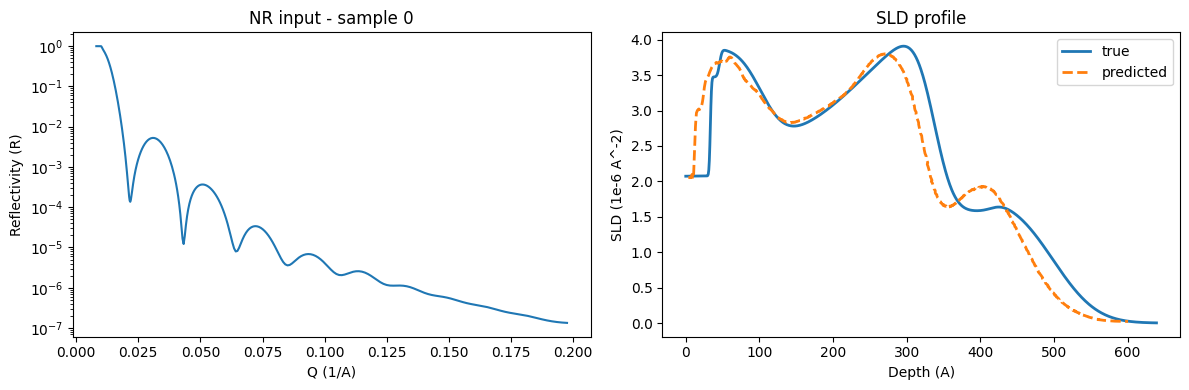

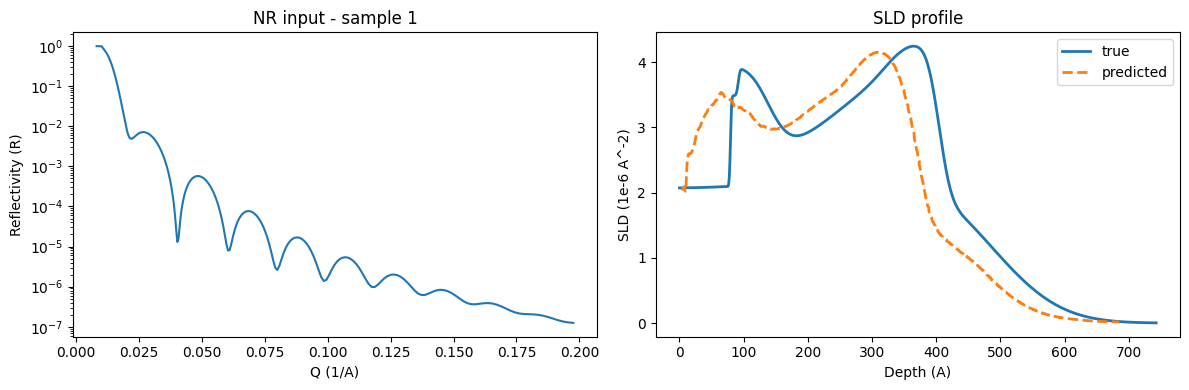

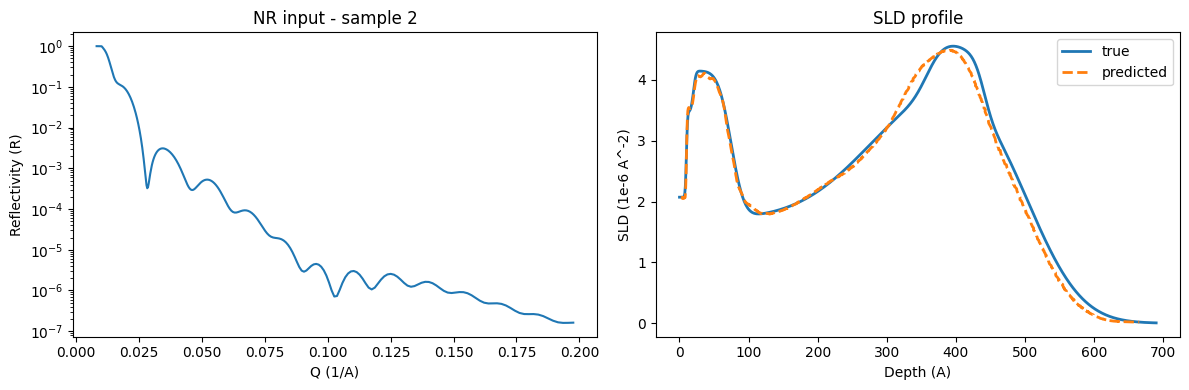

In [10]:
def split_profile(profile):
    arr = np.asarray(profile)
    if arr.shape[0] == 2:
        return arr[0], arr[1]
    if arr.shape[1] == 2:
        return arr[:, 0], arr[:, 1]
    raise ValueError(f"Unexpected SLD shape: {arr.shape}")

def plot_pair(qr_pair, true_profile, pred_profile, title):
    q, r = qr_pair
    z_true, rho_true = split_profile(true_profile)
    z_pred, rho_pred = split_profile(pred_profile)

    fig, (ax_nr, ax_sld) = plt.subplots(1, 2, figsize=(12, 4))
    ax_nr.semilogy(q, np.clip(r, 1e-9, 1))
    ax_nr.set_xlabel("Q (1/A)")
    ax_nr.set_ylabel("Reflectivity (R)")
    ax_nr.set_title(f"NR input - {title}")

    ax_sld.plot(z_true, rho_true, label="true", lw=2)
    ax_sld.plot(z_pred, rho_pred, label="predicted", lw=2, ls="--")
    ax_sld.set_xlabel("Depth (A)")
    ax_sld.set_ylabel("SLD (1e-6 A^-2)")
    ax_sld.set_title("SLD profile")
    ax_sld.legend()
    fig.tight_layout()
    return fig

for idx in range(min(3, len(nr_batch))):
    plot_pair(nr_batch[idx], true_sld[idx], y_pred[idx], f"sample {idx}")
plt.show()

## 8. Basic error metrics

A quick MSE/R2 check on the same batch (for larger evaluations, loop over the full test set).


In [ ]:
def r2_score_np(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

mse = np.mean((true_sld[: len(y_pred)] - y_pred) ** 2)
norm_mse = mse / np.var(true_sld[: len(y_pred)])
r2 = r2_score_np(true_sld[: len(y_pred)], y_pred)

print(f"MSE: {mse:.6f}")
print(f"Normalized MSE: {norm_mse:.6f}")
print(f"R2: {r2:.4f}")